### Original source  
https://github.com/LeonardoBerti00/TABL-Temporal-Attention-Augmented-Bilinear-Network-for-Financial-Time-Series-Data-Analysis

### **TABL**

In [1]:
# load packages

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils import data
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### **Data**
The dataset in the folder Dataset is the FI-2010 dataset zipped and normalized. 

As in the original paper I used the firs 7 days to train and to validate, and the rest 3 days to do the the testing. 

In [26]:
# please change the data_path to your local path and download the files you need from the web site of the dataset

#dec_data = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_7.txt')
#dec_data = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_7.txt')
dec_data = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Training/Train_Dst_Auction_ZScore_CF_7.txt')
dec_train = dec_data[:, :int(dec_data.shape[1] * 0.8)]
dec_val = dec_data[:, int(dec_data.shape[1] * 0.8):]

#dec_test1 = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_7.txt')
#dec_test2 = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_8.txt')
#dec_test3 = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_9.txt')
dec_test1 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_7.txt')
dec_test2 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_8.txt')
dec_test3 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_9.txt')
#dec_test1 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/3.Auction_DecPre/Auction_DecPre_Testing/Test_Dst_Auction_DecPre_CF_7.txt')
#dec_test2 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/3.Auction_DecPre/Auction_DecPre_Testing/Test_Dst_Auction_DecPre_CF_8.txt')
#dec_test3 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/3.Auction_DecPre/Auction_DecPre_Testing/Test_Dst_Auction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

# dec_train.shape = (149, 203800)

h = 2        #if h = 2, than horizon = 50
T = 50      #horizon 
dim = 10
k = T//10    #horizon

y_train = dec_train[-h, :].flatten()
# y_train.shape = (203800,)
y_val = dec_val[-h, :].flatten()
y_test = dec_test[-h, :].flatten()

# 10-1: 10 means the length of inputs
# second -1 means [1,2,3] to [0,1,2] conversion of class id
#y_train = y_train[dim-1+(k-1):] - 1
y_train = y_train[dim-1:] - 1
# y_train.shape = (203791,) # 203791 = 203800-(10+1)
#y_val = y_val[dim-1+(k-1):] - 1
y_val = y_val[dim-1:] - 1
#y_test = y_test[dim-1+(k-1):] - 1 
y_test = y_test[dim-1:] - 1 

# First 40 features = 10*4 features
dec_train = dec_train[:40, :].T
# dec_train.shape = (203800, 40)
dec_val = dec_val[:40, :].T
dec_test = dec_test[:40, :].T

In [3]:
#decpre_data = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/3.NoAuction_DecPre/NoAuction_DecPre_Training/Train_Dst_NoAuction_DecPre_CF_7.txt')
# Auction
#decpre_data = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/3.Auction_DecPre/Auction_DecPre_Training/Train_Dst_Auction_DecPre_CF_7.txt')
#decpre_data = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/3.Auction_DecPre/Auction_DecPre_Testing/Test_Dst_Auction_DecPre_CF_7.txt')
decpre_test1 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/3.Auction_DecPre/Auction_DecPre_Testing/Test_Dst_Auction_DecPre_CF_7.txt')
decpre_test2 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/3.Auction_DecPre/Auction_DecPre_Testing/Test_Dst_Auction_DecPre_CF_8.txt')
decpre_test3 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/3.Auction_DecPre/Auction_DecPre_Testing/Test_Dst_Auction_DecPre_CF_9.txt')
decpre_data = np.hstack((decpre_test1, decpre_test2, decpre_test3))
#decpre_data = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_7.txt')
decpre_train = decpre_data[:, :int(decpre_data.shape[1] * 0.8)]
decpre_val = decpre_data[:, int(decpre_data.shape[1] * 0.8):]
print(decpre_train.shape)

(149, 124139)


In [6]:
y_decpre_train = decpre_train[-h, :].flatten()
# y_train.shape = (203800,)
y_decpre_val = decpre_val[-h, :].flatten()
y_decpre_train = y_decpre_train - 1

decpre_all_train = decpre_train.T
# First 40 features = 10*4 features
decpre_train = decpre_train[:40, :].T
# dec_train.shape = (203800, 40)
decpre_val = decpre_val[:40, :].T

In [7]:
decpre_all_train.shape, decpre_train.shape, y_decpre_train.shape

((124139, 149), (124139, 40), (124139,))

In [10]:
mid = (decpre_all_train[:, 0]+decpre_all_train[:, 2])/2

In [16]:
y_label = decpre_all_train[:, -h] - 1

In [19]:
thres = 0.00002
thres1 = thres
thres2 = thres

#thres1 = 0.00002
#thres2 = 0.00002

k = 5

n = mid.shape[0] - k

offset = k-1
#for i in range(30):
#    y_label[i] = i
y_label_shift = y_label[offset:]

matching_cnt = 0
total_cnt = 0
for i in range(n):
    total_cnt += 1
    #m_i = np.mean(mid0[i-k+1:i+1])
    m_i = mid[i]
    l_i = (np.mean(mid[i+1:i+1+(k-1)])-m_i)/m_i
    if l_i >= thres1:
        y = 0
    elif l_i <= -thres2:
        y = 2
    else:
        y = 1
    #if i < 100:
        #print(y, int(y_label_shift[i]), l_i)
    if y == int(y_label_shift[i]):
        matching_cnt += 1

print('horizon = %d, matching ratio = %f'%(k, matching_cnt/total_cnt)) 

horizon = 5, matching ratio = 0.903653


In [27]:
#computing the weights for the weighted cross entropy loss
def compute_weights(y):
  cont_0 = 0
  cont_1 = 0
  cont_2 = 0
  for i in range(y.shape[0]):
    if (y[i] == 0):
      cont_0 += 1
    elif (y[i] == 1):
      cont_1 += 1
    elif (y[i] == 2):
      cont_2 += 2
    else: 
      raise Exception("wrong labels")
  return torch.Tensor([1e6/cont_0, 1e6/cont_1, 1e6/cont_2]).to(device)

y_total = np.concatenate((y_train, y_val, y_test))
weights = compute_weights(y_total)

In [28]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, x, y, num_classes, dim):
        """Initialization""" 
        self.num_classes = num_classes
        self.dim = dim
        self.x = x   
        self.y = y

        self.length = x.shape[0] - (T/10) -self.dim + 1
        print(self.length)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return int(self.length)

    def __getitem__(self, i):
        input = self.x[i:i+self.dim, :]
        input = input.permute(1, 2, 0)
        input = torch.squeeze(input)

        return input, self.y[i]

In [29]:
#Hyperparameters
batch_size = 256
epochs = 200
   
lr = 0.01
num_classes = 3
dim = 10

dataset_val = Dataset(dec_val, y_val, num_classes, dim)
dataset_test = Dataset(dec_test, y_test, num_classes, dim)
dataset_train = Dataset(dec_train, y_train, num_classes, dim)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

60577.0
155160.0
242346.0


In [36]:
dec_train[0, 0]

0.35983073

In [37]:
for i,(x,y) in enumerate(dataset_train):
    print(x.shape, y.shape)
    n = x.shape[0]
    mids = (x[0, :] + x[2, :])/2
    print(mids)
    break

torch.Size([40, 10]) torch.Size([])
tensor([0.3543, 0.3688, 0.3688, 0.3688, 0.3688, 0.3708, 0.3673, 0.3673, 0.3688,
        0.3673], dtype=torch.float64)


### **Model Architecture**


In [6]:
class TABL_layer(nn.Module):
    def __init__(self, d2, d1, t1, t2):
        super().__init__()
        self.t1 = t1

        weight = torch.Tensor(d2, d1)
        self.W1 = nn.Parameter(weight)
        nn.init.kaiming_uniform_(self.W1, nonlinearity='relu')
        
        weight2 = torch.Tensor(t1, t1)
        self.W = nn.Parameter(weight2)
        nn.init.constant_(self.W, 1/t1)
 
        weight3 = torch.Tensor(t1, t2)
        self.W2 = nn.Parameter(weight3)
        nn.init.kaiming_uniform_(self.W2, nonlinearity='relu')

        bias1 = torch.Tensor(d2, t2)
        self.B = nn.Parameter(bias1)
        nn.init.constant_(self.B, 0)

        l = torch.Tensor(1,)
        self.l = nn.Parameter(l)
        nn.init.constant_(self.l, 0.5)

        self.activation = nn.ReLU()

    def forward(self, X):
        
        #maintaining the weight parameter between 0 and 1.
        if (self.l[0] < 0): 
          l = torch.Tensor(1,)
          self.l = nn.Parameter(l)
          nn.init.constant_(self.l, 0.0)

        if (self.l[0] > 1): 
          l = torch.Tensor(1,)
          self.l = nn.Parameter(l)
          nn.init.constant_(self.l, 1.0)
     
        #modelling the dependence along the first mode of X while keeping the temporal order intact (7)
        X = self.W1 @ X

        #enforcing constant (1) on the diagonal
        W = self.W -self.W *torch.eye(self.t1,dtype=torch.float32).to(device)+torch.eye(self.t1,dtype=torch.float32).to(device)/self.t1

        #attention, the aim of the second step is to learn how important the temporal instances are to each other (8)
        E = X @ W

        #computing the attention mask  (9)
        A = torch.softmax(E, dim=-1)

        #applying a soft attention mechanism  (10)
        #he attention mask A obtained from the third step is used to zero out the effect of unimportant elements
        X = self.l[0] * (X) + (1.0 - self.l[0])*X*A

        #the final step of the proposed layer estimates the temporal mapping W2, after the bias shift (11)
        y = X @ self.W2 + self.B
        return y

class BL_layer(nn.Module):
  def __init__(self, d2, d1, t1, t2):
        super().__init__()
        weight1 = torch.Tensor(d2, d1)
        self.W1 = nn.Parameter(weight1)
        nn.init.kaiming_uniform_(self.W1, nonlinearity='relu')

        weight2 = torch.Tensor(t1, t2)
        self.W2 = nn.Parameter(weight2)
        nn.init.kaiming_uniform_(self.W2, nonlinearity='relu')

        bias1 = torch.zeros((d2, t2))
        self.B = nn.Parameter(bias1)
        nn.init.constant_(self.B, 0)

        self.activation = nn.ReLU()

  def forward(self, x):

    x = self.activation(self.W1 @ x @ self.W2 + self.B)

    return x


class BTABL(nn.Module):
  def __init__(self, d2, d1, t1, t2, d3, t3):
    super().__init__()

    self.BL = BL_layer(d2, d1, t1, t2)
    self.TABL = TABL_layer(d3, d2, t2, t3)
    self.dropout = nn.Dropout(0.1)

  def forward(self, x):

    self.max_norm_(self.BL.W1.data)
    self.max_norm_(self.BL.W2.data)
    x = self.BL(x)
    x = self.dropout(x)

    self.max_norm_(self.TABL.W1.data)
    self.max_norm_(self.TABL.W.data)
    self.max_norm_(self.TABL.W2.data)
    x = self.TABL(x)
    x = torch.squeeze(x)
    x = torch.softmax(x, 1)
    return x

  def max_norm_(self, w):
    with torch.no_grad():
      if (torch.linalg.matrix_norm(w) > 10.0):
        norm = torch.linalg.matrix_norm(w)
        desired = torch.clamp(norm, min=0.0, max=10.0)
        w *= (desired / (1e-8 + norm))



class CTABL(nn.Module):
  def __init__(self, d2, d1, t1, t2, d3, t3, d4, t4):
    super().__init__()
    
    self.BL = BL_layer(d2, d1, t1, t2)
    self.BL2 = BL_layer(d3, d2, t2, t3)
    self.TABL = TABL_layer(d4, d3, t3, t4)
    self.dropout = nn.Dropout(0.1)

  def forward(self, x):
 
    self.max_norm_(self.BL.W1.data)
    self.max_norm_(self.BL.W2.data)
    x = self.BL(x)
    x = self.dropout(x)

    self.max_norm_(self.BL2.W1.data)
    self.max_norm_(self.BL2.W2.data)
    x = self.BL2(x)
    x = self.dropout(x)

    self.max_norm_(self.TABL.W1.data)
    self.max_norm_(self.TABL.W.data)
    self.max_norm_(self.TABL.W2.data)
    x = self.TABL(x)
    x = torch.squeeze(x)
    x = torch.softmax(x, 1)
    return x

  def max_norm_(self, w):
    with torch.no_grad():
      if (torch.linalg.matrix_norm(w) > 10.0):
        norm = torch.linalg.matrix_norm(w)
        desired = torch.clamp(norm, min=0.0, max=10.0)
        w *= (desired / (1e-8 + norm))
    

In [18]:
class BiN(nn.Module):
    def __init__(self, d2, d1, t1, t2):
        super().__init__()
        self.t1 = t1
        self.d1 = d1
        self.t2 = t2
        self.d2 = d2

        bias1 = torch.Tensor(t1, 1)
        self.B1 = nn.Parameter(bias1)
        nn.init.constant_(self.B1, 0)

        l1 = torch.Tensor(t1, 1)
        self.l1 = nn.Parameter(l1)
        nn.init.xavier_normal_(self.l1)

        bias2 = torch.Tensor(d1, 1)
        self.B2 = nn.Parameter(bias2)
        nn.init.constant_(self.B2, 0)

        l2 = torch.Tensor(d1, 1)
        self.l2 = nn.Parameter(l2)
        nn.init.xavier_normal_(self.l2)

        y1 = torch.Tensor(1, )
        self.y1 = nn.Parameter(y1)
        nn.init.constant_(self.y1, 0.5)

        y2 = torch.Tensor(1, )
        self.y2 = nn.Parameter(y2)
        nn.init.constant_(self.y2, 0.5)

    def forward(self, x):

        # if the two scalars are negative then we setting them to 0
        if (self.y1[0] < 0):
            y1 = torch.cuda.FloatTensor(1, )
            self.y1 = nn.Parameter(y1)
            nn.init.constant_(self.y1, 0.01)

        if (self.y2[0] < 0):
            y2 = torch.cuda.FloatTensor(1, )
            self.y2 = nn.Parameter(y2)
            nn.init.constant_(self.y2, 0.01)

        # normalization along the temporal dimensione
        #T2 = torch.ones([self.t1, 1], device=cst.DEVICE_TYPE)
        T2 = torch.ones([self.t1, 1], device=device)
        x2 = torch.mean(x, dim=2)
        x2 = torch.reshape(x2, (x2.shape[0], x2.shape[1], 1))

        std = torch.std(x, dim=2)
        std = torch.reshape(std, (std.shape[0], std.shape[1], 1))
        # it can be possible that the std of some temporal slices is 0, and this produces inf values, so we have to set them to one
        std[std < 1e-4] = 1

        diff = x - (x2 @ (T2.T))
        Z2 = diff / (std @ (T2.T))

        X2 = self.l2 @ T2.T
        X2 = X2 * Z2
        X2 = X2 + (self.B2 @ T2.T)

        # normalization along the feature dimension
        #T1 = torch.ones([self.d1, 1], device=cst.DEVICE_TYPE)
        T1 = torch.ones([self.d1, 1], device=device)
        x1 = torch.mean(x, dim=1)
        x1 = torch.reshape(x1, (x1.shape[0], x1.shape[1], 1))

        std = torch.std(x, dim=1)
        std = torch.reshape(std, (std.shape[0], std.shape[1], 1))

        op1 = x1 @ T1.T
        op1 = torch.permute(op1, (0, 2, 1))

        op2 = std @ T1.T
        op2 = torch.permute(op2, (0, 2, 1))

        z1 = (x - op1) / (op2)
        X1 = (T1 @ self.l1.T)
        X1 = X1 * z1
        X1 = X1 + (T1 @ self.B1.T)

        # weighing the imporance of temporal and feature normalization
        x = self.y1 * X1 + self.y2 * X2

        return x
        
class BL_layer(nn.Module):
  def __init__(self, d2, d1, t1, t2):
        super().__init__()
        weight1 = torch.Tensor(d2, d1)
        self.W1 = nn.Parameter(weight1)
        nn.init.kaiming_uniform_(self.W1, nonlinearity='relu')

        weight2 = torch.Tensor(t1, t2)
        self.W2 = nn.Parameter(weight2)
        nn.init.kaiming_uniform_(self.W2, nonlinearity='relu')

        bias1 = torch.zeros((d2, t2))
        self.B = nn.Parameter(bias1)
        nn.init.constant_(self.B, 0)

        self.activation = nn.ReLU()

  def forward(self, x):

    x = self.activation(self.W1 @ x @ self.W2 + self.B)

    return x

class TABL_layer(nn.Module):
    def __init__(self, d2, d1, t1, t2):
        super().__init__()
        self.t1 = t1

        weight = torch.Tensor(d2, d1)
        self.W1 = nn.Parameter(weight)
        nn.init.kaiming_uniform_(self.W1, nonlinearity='relu')

        weight2 = torch.Tensor(t1, t1)
        self.W = nn.Parameter(weight2)
        nn.init.constant_(self.W, 1 / t1)

        weight3 = torch.Tensor(t1, t2)
        self.W2 = nn.Parameter(weight3)
        nn.init.kaiming_uniform_(self.W2, nonlinearity='relu')

        bias1 = torch.Tensor(d2, t2)
        self.B = nn.Parameter(bias1)
        nn.init.constant_(self.B, 0)

        l = torch.Tensor(1, )
        self.l = nn.Parameter(l)
        nn.init.constant_(self.l, 0.5)

        self.activation = nn.ReLU()

    def forward(self, X):

        # maintaining the weight parameter between 0 and 1.
        if (self.l[0] < 0):
            l = torch.Tensor(1, )
            self.l = nn.Parameter(l)
            nn.init.constant_(self.l, 0.0)

        if (self.l[0] > 1):
            l = torch.Tensor(1, )
            self.l = nn.Parameter(l)
            nn.init.constant_(self.l, 1.0)

        # modelling the dependence along the first mode of X while keeping the temporal order intact (7)
        X = self.W1 @ X

        # enforcing constant (1) on the diagonal
        #W = self.W - self.W * torch.eye(self.t1, dtype=torch.float32, device=cst.DEVICE_TYPE) + torch.eye(self.t1, dtype=torch.float32, device=cst.DEVICE_TYPE) / self.t1
        W = self.W - self.W * torch.eye(self.t1, dtype=torch.float32, device=device) + torch.eye(self.t1, dtype=torch.float32, device=device) / self.t1

        # attention, the aim of the second step is to learn how important the temporal instances are to each other (8)
        E = X @ W

        # computing the attention mask  (9)
        A = torch.softmax(E, dim=-1)

        # applying a soft attention mechanism  (10)
        # he attention mask A obtained from the third step is used to zero out the effect of unimportant elements
        X = self.l[0] * (X) + (1.0 - self.l[0]) * X * A

        # the final step of the proposed layer estimates the temporal mapping W2, after the bias shift (11)
        y = X @ self.W2 + self.B
        return y


class BiN_CTABL(nn.Module):
    # d2=60, d1=40, t1=10, t2=10, d3=120, t3=5, d4=3, t4=1
    def __init__(self, d2, d1, t1, t2, d3, t3, d4, t4):
        super().__init__()

        self.BiN = BiN(d2, d1, t1, t2)
        self.BL = BL_layer(d2, d1, t1, t2)
        self.BL2 = BL_layer(d3, d2, t2, t3)
        # d4=3, d3=120, t3=5, t4=1
        self.TABL = TABL_layer(d4, d3, t3, t4)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):

        # x.shape = (32, 40, 10)
        # first of all we pass the input to the BiN layer, then we use the C(TABL) architecture
        #x = torch.permute(x, (0, 2, 1))

        x = self.BiN(x)

        self.max_norm_(self.BL.W1.data)
        self.max_norm_(self.BL.W2.data)
        x = self.BL(x)
        x = self.dropout(x)

        self.max_norm_(self.BL2.W1.data)
        self.max_norm_(self.BL2.W2.data)
        x = self.BL2(x)
        x = self.dropout(x)

        self.max_norm_(self.TABL.W1.data)
        self.max_norm_(self.TABL.W.data)
        self.max_norm_(self.TABL.W2.data)
        x = self.TABL(x)
        # x.shape = (32, 3, 1)
        x = torch.squeeze(x)
        # x.shape = (32, 3)
        x = torch.softmax(x, 1)
        # x.shape = (32, 3)

        return x

    def max_norm_(self, w):
        with torch.no_grad():
            if (torch.linalg.matrix_norm(w) > 10.0):
                norm = torch.linalg.matrix_norm(w)
                desired = torch.clamp(norm, min=0.0, max=10.0)
                w *= (desired / (1e-8 + norm))


### **Model Training**

I implemented the second setting of the experiment

In [19]:
#Choose between B(TABL) and C(TABL)

#model = BTABL(120, 40, 10, 5, 3, 1)
#model = CTABL(60, 40, 10, 10, 120, 5, 3, 1)
model = BiN_CTABL(60, 40, 10, 10, 120, 5, 3, 1)

model.to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

def batch_gd(model, criterion, optimizer, epochs):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0
    SC = [0.005, 0.001, 0.0005, 0.0001]
    i = 0
    for it in tqdm(range(epochs)):
        
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print('### debug 22')
            #print(outputs.shape)
            #print(targets.shape)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss)
        
        if (train_losses[it-1] <= train_loss and i < 4 and it != 0):
              for g in optimizer.param_groups:
                g['lr'] = SC[i]
              i += 1
              

        model.eval()
        test_loss = []
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            #outputs = torch.squeeze(outputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        #We save the best model
        if test_loss < best_test_loss:
            torch.save(model, './best_model_CTABL')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')
        
    #torch.save(model, '/content/drive/MyDrive/Output/best_model_translob_FI')
    return train_losses, test_losses

------- List Hyper Parameters -------
epochs   ->   200
learningRate   ->   0.01
horizon    ->     50
batch size   ->    256
Optimizer   ->    SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


  0%|▍                                                                            | 1/200 [00:09<32:02,  9.66s/it]

model saved
Epoch 1/200, Train Loss: 0.8035,           Validation Loss: 0.6767, Duration: 0:00:09.658602, Best Val Epoch: 0


  1%|▊                                                                            | 2/200 [00:19<31:28,  9.54s/it]

model saved
Epoch 2/200, Train Loss: 0.6732,           Validation Loss: 0.6630, Duration: 0:00:09.452402, Best Val Epoch: 1


  2%|█▏                                                                           | 3/200 [00:29<32:04,  9.77s/it]

model saved
Epoch 3/200, Train Loss: 0.6701,           Validation Loss: 0.6614, Duration: 0:00:10.046377, Best Val Epoch: 2


  2%|█▌                                                                           | 4/200 [00:39<32:30,  9.95s/it]

model saved
Epoch 4/200, Train Loss: 0.6696,           Validation Loss: 0.6612, Duration: 0:00:10.233973, Best Val Epoch: 3


  2%|█▉                                                                           | 5/200 [00:48<31:40,  9.75s/it]

Epoch 5/200, Train Loss: 0.6693,           Validation Loss: 0.6621, Duration: 0:00:09.376620, Best Val Epoch: 3


  3%|██▎                                                                          | 6/200 [00:58<31:21,  9.70s/it]

model saved
Epoch 6/200, Train Loss: 0.6690,           Validation Loss: 0.6611, Duration: 0:00:09.611008, Best Val Epoch: 5


  4%|██▋                                                                          | 7/200 [01:07<31:01,  9.65s/it]

model saved
Epoch 7/200, Train Loss: 0.6686,           Validation Loss: 0.6610, Duration: 0:00:09.536598, Best Val Epoch: 6


  4%|███                                                                          | 8/200 [01:18<31:34,  9.87s/it]

model saved
Epoch 8/200, Train Loss: 0.6686,           Validation Loss: 0.6607, Duration: 0:00:10.331105, Best Val Epoch: 7


  4%|███▍                                                                         | 9/200 [01:28<31:18,  9.83s/it]

Epoch 9/200, Train Loss: 0.6684,           Validation Loss: 0.6607, Duration: 0:00:09.759938, Best Val Epoch: 7


  5%|███▊                                                                        | 10/200 [01:38<31:23,  9.91s/it]

model saved
Epoch 10/200, Train Loss: 0.6681,           Validation Loss: 0.6605, Duration: 0:00:10.090426, Best Val Epoch: 9


  6%|████▏                                                                       | 11/200 [01:48<31:25,  9.98s/it]

model saved
Epoch 11/200, Train Loss: 0.6683,           Validation Loss: 0.6604, Duration: 0:00:10.126583, Best Val Epoch: 10


  6%|████▌                                                                       | 12/200 [01:58<31:09,  9.94s/it]

model saved
Epoch 12/200, Train Loss: 0.6679,           Validation Loss: 0.6602, Duration: 0:00:09.857413, Best Val Epoch: 11


  6%|████▉                                                                       | 13/200 [02:07<30:33,  9.81s/it]

Epoch 13/200, Train Loss: 0.6680,           Validation Loss: 0.6603, Duration: 0:00:09.490254, Best Val Epoch: 11


  7%|█████▎                                                                      | 14/200 [02:17<30:20,  9.79s/it]

Epoch 14/200, Train Loss: 0.6679,           Validation Loss: 0.6603, Duration: 0:00:09.753200, Best Val Epoch: 11


  8%|█████▋                                                                      | 15/200 [02:27<30:36,  9.93s/it]

Epoch 15/200, Train Loss: 0.6678,           Validation Loss: 0.6603, Duration: 0:00:10.250190, Best Val Epoch: 11


  8%|██████                                                                      | 16/200 [02:37<30:23,  9.91s/it]

Epoch 16/200, Train Loss: 0.6679,           Validation Loss: 0.6604, Duration: 0:00:09.862834, Best Val Epoch: 11


  8%|██████▍                                                                     | 17/200 [02:47<30:02,  9.85s/it]

Epoch 17/200, Train Loss: 0.6678,           Validation Loss: 0.6604, Duration: 0:00:09.710092, Best Val Epoch: 11


  9%|██████▊                                                                     | 18/200 [02:56<29:33,  9.74s/it]

Epoch 18/200, Train Loss: 0.6678,           Validation Loss: 0.6604, Duration: 0:00:09.497874, Best Val Epoch: 11


 10%|███████▏                                                                    | 19/200 [03:06<29:27,  9.76s/it]

Epoch 19/200, Train Loss: 0.6680,           Validation Loss: 0.6604, Duration: 0:00:09.807485, Best Val Epoch: 11


 10%|███████▌                                                                    | 20/200 [03:16<29:25,  9.81s/it]

Epoch 20/200, Train Loss: 0.6678,           Validation Loss: 0.6604, Duration: 0:00:09.919963, Best Val Epoch: 11


 10%|███████▉                                                                    | 21/200 [03:26<29:07,  9.76s/it]

Epoch 21/200, Train Loss: 0.6678,           Validation Loss: 0.6604, Duration: 0:00:09.652712, Best Val Epoch: 11


 11%|████████▎                                                                   | 22/200 [03:36<29:17,  9.87s/it]

Epoch 22/200, Train Loss: 0.6678,           Validation Loss: 0.6604, Duration: 0:00:10.129957, Best Val Epoch: 11


 12%|████████▋                                                                   | 23/200 [03:46<29:29, 10.00s/it]

Epoch 23/200, Train Loss: 0.6678,           Validation Loss: 0.6603, Duration: 0:00:10.277495, Best Val Epoch: 11


 12%|█████████                                                                   | 24/200 [03:56<29:15,  9.97s/it]

Epoch 24/200, Train Loss: 0.6677,           Validation Loss: 0.6603, Duration: 0:00:09.921588, Best Val Epoch: 11


 12%|█████████▌                                                                  | 25/200 [04:05<28:42,  9.84s/it]

Epoch 25/200, Train Loss: 0.6677,           Validation Loss: 0.6603, Duration: 0:00:09.537372, Best Val Epoch: 11


 13%|█████████▉                                                                  | 26/200 [04:16<28:53,  9.96s/it]

Epoch 26/200, Train Loss: 0.6678,           Validation Loss: 0.6603, Duration: 0:00:10.235527, Best Val Epoch: 11


 14%|██████████▎                                                                 | 27/200 [04:26<28:43,  9.96s/it]

Epoch 27/200, Train Loss: 0.6676,           Validation Loss: 0.6603, Duration: 0:00:09.967810, Best Val Epoch: 11


 14%|██████████▋                                                                 | 28/200 [04:36<28:57, 10.10s/it]

Epoch 28/200, Train Loss: 0.6677,           Validation Loss: 0.6603, Duration: 0:00:10.422366, Best Val Epoch: 11


 14%|███████████                                                                 | 29/200 [04:46<28:21,  9.95s/it]

Epoch 29/200, Train Loss: 0.6677,           Validation Loss: 0.6603, Duration: 0:00:09.605258, Best Val Epoch: 11


 15%|███████████▍                                                                | 30/200 [04:55<27:41,  9.78s/it]

Epoch 30/200, Train Loss: 0.6676,           Validation Loss: 0.6603, Duration: 0:00:09.360035, Best Val Epoch: 11


 16%|███████████▊                                                                | 31/200 [05:05<27:32,  9.78s/it]

Epoch 31/200, Train Loss: 0.6678,           Validation Loss: 0.6603, Duration: 0:00:09.780915, Best Val Epoch: 11


 16%|████████████▏                                                               | 32/200 [05:14<27:14,  9.73s/it]

model saved
Epoch 32/200, Train Loss: 0.6679,           Validation Loss: 0.6602, Duration: 0:00:09.617865, Best Val Epoch: 31


 16%|████████████▌                                                               | 33/200 [05:24<27:01,  9.71s/it]

Epoch 33/200, Train Loss: 0.6679,           Validation Loss: 0.6602, Duration: 0:00:09.660829, Best Val Epoch: 31


 17%|████████████▉                                                               | 34/200 [05:34<27:03,  9.78s/it]

Epoch 34/200, Train Loss: 0.6679,           Validation Loss: 0.6602, Duration: 0:00:09.954136, Best Val Epoch: 31


 18%|█████████████▎                                                              | 35/200 [05:44<27:03,  9.84s/it]

model saved
Epoch 35/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.962377, Best Val Epoch: 34


 18%|█████████████▋                                                              | 36/200 [05:54<26:57,  9.86s/it]

Epoch 36/200, Train Loss: 0.6678,           Validation Loss: 0.6602, Duration: 0:00:09.917785, Best Val Epoch: 34


 18%|██████████████                                                              | 37/200 [06:04<27:01,  9.95s/it]

model saved
Epoch 37/200, Train Loss: 0.6678,           Validation Loss: 0.6602, Duration: 0:00:10.148382, Best Val Epoch: 36


 19%|██████████████▍                                                             | 38/200 [06:14<26:38,  9.87s/it]

Epoch 38/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.673088, Best Val Epoch: 36


 20%|██████████████▊                                                             | 39/200 [06:23<26:23,  9.83s/it]

Epoch 39/200, Train Loss: 0.6678,           Validation Loss: 0.6602, Duration: 0:00:09.756825, Best Val Epoch: 36


 20%|███████████████▏                                                            | 40/200 [06:33<26:15,  9.85s/it]

Epoch 40/200, Train Loss: 0.6679,           Validation Loss: 0.6602, Duration: 0:00:09.874987, Best Val Epoch: 36


 20%|███████████████▌                                                            | 41/200 [06:43<25:49,  9.75s/it]

Epoch 41/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.512350, Best Val Epoch: 36


 21%|███████████████▉                                                            | 42/200 [06:53<25:41,  9.76s/it]

Epoch 42/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.784099, Best Val Epoch: 36


 22%|████████████████▎                                                           | 43/200 [07:03<25:38,  9.80s/it]

Epoch 43/200, Train Loss: 0.6678,           Validation Loss: 0.6602, Duration: 0:00:09.899899, Best Val Epoch: 36


 22%|████████████████▋                                                           | 44/200 [07:13<25:44,  9.90s/it]

Epoch 44/200, Train Loss: 0.6678,           Validation Loss: 0.6602, Duration: 0:00:10.124200, Best Val Epoch: 36


 22%|█████████████████                                                           | 45/200 [07:22<25:24,  9.84s/it]

Epoch 45/200, Train Loss: 0.6678,           Validation Loss: 0.6603, Duration: 0:00:09.690530, Best Val Epoch: 36


 23%|█████████████████▍                                                          | 46/200 [07:32<25:13,  9.83s/it]

Epoch 46/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.804867, Best Val Epoch: 36


 24%|█████████████████▊                                                          | 47/200 [07:42<25:20,  9.94s/it]

Epoch 47/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:10.190451, Best Val Epoch: 36


 24%|██████████████████▏                                                         | 48/200 [07:52<24:55,  9.84s/it]

Epoch 48/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.610494, Best Val Epoch: 36


 24%|██████████████████▌                                                         | 49/200 [08:02<24:52,  9.89s/it]

model saved
Epoch 49/200, Train Loss: 0.6679,           Validation Loss: 0.6602, Duration: 0:00:10.000171, Best Val Epoch: 48


 25%|███████████████████                                                         | 50/200 [08:12<24:33,  9.83s/it]

model saved
Epoch 50/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.679458, Best Val Epoch: 49


 26%|███████████████████▍                                                        | 51/200 [08:22<24:41,  9.94s/it]

Epoch 51/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:10.220737, Best Val Epoch: 49


 26%|███████████████████▊                                                        | 52/200 [08:32<24:20,  9.87s/it]

Epoch 52/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.689682, Best Val Epoch: 49


 26%|████████████████████▏                                                       | 53/200 [08:42<24:36, 10.05s/it]

Epoch 53/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:10.461092, Best Val Epoch: 49


 27%|████████████████████▌                                                       | 54/200 [08:52<24:28, 10.06s/it]

model saved
Epoch 54/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:10.092141, Best Val Epoch: 53


 28%|████████████████████▉                                                       | 55/200 [09:02<24:24, 10.10s/it]

model saved
Epoch 55/200, Train Loss: 0.6678,           Validation Loss: 0.6602, Duration: 0:00:10.189955, Best Val Epoch: 54


 28%|█████████████████████▎                                                      | 56/200 [09:12<24:08, 10.06s/it]

Epoch 56/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.970875, Best Val Epoch: 54


 28%|█████████████████████▋                                                      | 57/200 [09:22<23:55, 10.04s/it]

Epoch 57/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.978725, Best Val Epoch: 54


 29%|██████████████████████                                                      | 58/200 [09:32<23:38,  9.99s/it]

Epoch 58/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.875678, Best Val Epoch: 54


 30%|██████████████████████▍                                                     | 59/200 [09:42<23:24,  9.96s/it]

Epoch 59/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.897563, Best Val Epoch: 54


 30%|██████████████████████▊                                                     | 60/200 [09:53<23:40, 10.15s/it]

model saved
Epoch 60/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:10.576604, Best Val Epoch: 59


 30%|███████████████████████▏                                                    | 61/200 [10:03<23:18, 10.06s/it]

model saved
Epoch 61/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.867863, Best Val Epoch: 60


 31%|███████████████████████▌                                                    | 62/200 [10:13<23:30, 10.22s/it]

model saved
Epoch 62/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:10.576944, Best Val Epoch: 61


 32%|███████████████████████▉                                                    | 63/200 [10:23<22:58, 10.06s/it]

Epoch 63/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.701700, Best Val Epoch: 61


 32%|████████████████████████▎                                                   | 64/200 [10:33<22:44, 10.04s/it]

model saved
Epoch 64/200, Train Loss: 0.6679,           Validation Loss: 0.6602, Duration: 0:00:09.971622, Best Val Epoch: 63


 32%|████████████████████████▋                                                   | 65/200 [10:43<22:23,  9.96s/it]

model saved
Epoch 65/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.766478, Best Val Epoch: 64


 33%|█████████████████████████                                                   | 66/200 [10:52<22:07,  9.91s/it]

Epoch 66/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.791375, Best Val Epoch: 64


 34%|█████████████████████████▍                                                  | 67/200 [11:02<21:59,  9.92s/it]

model saved
Epoch 67/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.952847, Best Val Epoch: 66


 34%|█████████████████████████▊                                                  | 68/200 [11:13<22:16, 10.13s/it]

model saved
Epoch 68/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:10.603559, Best Val Epoch: 67


 34%|██████████████████████████▏                                                 | 69/200 [11:23<22:06, 10.13s/it]

Epoch 69/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:10.136829, Best Val Epoch: 67


 35%|██████████████████████████▌                                                 | 70/200 [11:33<21:52, 10.09s/it]

model saved
Epoch 70/200, Train Loss: 0.6678,           Validation Loss: 0.6602, Duration: 0:00:10.006713, Best Val Epoch: 69


 36%|██████████████████████████▉                                                 | 71/200 [11:43<21:35, 10.05s/it]

model saved
Epoch 71/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.934278, Best Val Epoch: 70


 36%|███████████████████████████▎                                                | 72/200 [11:53<21:10,  9.92s/it]

Epoch 72/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.633259, Best Val Epoch: 70


 36%|███████████████████████████▋                                                | 73/200 [12:03<21:13, 10.03s/it]

Epoch 73/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:10.269072, Best Val Epoch: 70


 37%|████████████████████████████                                                | 74/200 [12:13<21:14, 10.11s/it]

Epoch 74/200, Train Loss: 0.6678,           Validation Loss: 0.6602, Duration: 0:00:10.314415, Best Val Epoch: 70


 38%|████████████████████████████▌                                               | 75/200 [12:23<20:50, 10.01s/it]

Epoch 75/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.759523, Best Val Epoch: 70


 38%|████████████████████████████▉                                               | 76/200 [12:33<20:40, 10.00s/it]

Epoch 76/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.989075, Best Val Epoch: 70


 38%|█████████████████████████████▎                                              | 77/200 [12:43<20:34, 10.04s/it]

Epoch 77/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:10.129780, Best Val Epoch: 70


 39%|█████████████████████████████▋                                              | 78/200 [12:53<20:15,  9.96s/it]

Epoch 78/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.771297, Best Val Epoch: 70


 40%|██████████████████████████████                                              | 79/200 [13:03<19:58,  9.91s/it]

Epoch 79/200, Train Loss: 0.6679,           Validation Loss: 0.6602, Duration: 0:00:09.781260, Best Val Epoch: 70


 40%|██████████████████████████████▍                                             | 80/200 [13:13<19:50,  9.92s/it]

Epoch 80/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.946300, Best Val Epoch: 70


 40%|██████████████████████████████▊                                             | 81/200 [13:22<19:40,  9.92s/it]

Epoch 81/200, Train Loss: 0.6678,           Validation Loss: 0.6602, Duration: 0:00:09.916940, Best Val Epoch: 70


 41%|███████████████████████████████▏                                            | 82/200 [13:32<19:12,  9.77s/it]

Epoch 82/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.421191, Best Val Epoch: 70


 42%|███████████████████████████████▌                                            | 83/200 [13:41<18:54,  9.70s/it]

Epoch 83/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.531368, Best Val Epoch: 70


 42%|███████████████████████████████▉                                            | 84/200 [13:52<19:05,  9.88s/it]

Epoch 84/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:10.287825, Best Val Epoch: 70


 42%|████████████████████████████████▎                                           | 85/200 [14:02<18:56,  9.88s/it]

Epoch 85/200, Train Loss: 0.6678,           Validation Loss: 0.6602, Duration: 0:00:09.902643, Best Val Epoch: 70


 43%|████████████████████████████████▋                                           | 86/200 [14:12<18:55,  9.96s/it]

Epoch 86/200, Train Loss: 0.6675,           Validation Loss: 0.6602, Duration: 0:00:10.140013, Best Val Epoch: 70


 44%|█████████████████████████████████                                           | 87/200 [14:21<18:29,  9.82s/it]

Epoch 87/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.491847, Best Val Epoch: 70


 44%|█████████████████████████████████▍                                          | 88/200 [14:32<18:43, 10.03s/it]

Epoch 88/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:10.513780, Best Val Epoch: 70


 44%|█████████████████████████████████▊                                          | 89/200 [14:42<18:50, 10.18s/it]

Epoch 89/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:10.533755, Best Val Epoch: 70


 45%|██████████████████████████████████▏                                         | 90/200 [14:52<18:24, 10.04s/it]

Epoch 90/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.700352, Best Val Epoch: 70


 46%|██████████████████████████████████▌                                         | 91/200 [15:02<18:07,  9.97s/it]

Epoch 91/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.825037, Best Val Epoch: 70


 46%|██████████████████████████████████▉                                         | 92/200 [15:11<17:46,  9.88s/it]

Epoch 92/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.656302, Best Val Epoch: 70


 46%|███████████████████████████████████▎                                        | 93/200 [15:22<17:56, 10.06s/it]

Epoch 93/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:10.491303, Best Val Epoch: 70


 47%|███████████████████████████████████▋                                        | 94/200 [15:32<17:39,  9.99s/it]

Epoch 94/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.831689, Best Val Epoch: 70


 52%|██████████████████████████████████████▋                                    | 103/200 [17:01<16:00,  9.90s/it]

Epoch 103/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.845784, Best Val Epoch: 70


 52%|███████████████████████████████████████                                    | 104/200 [17:11<15:49,  9.89s/it]

Epoch 104/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.869674, Best Val Epoch: 70


 52%|███████████████████████████████████████▍                                   | 105/200 [17:21<15:53, 10.04s/it]

Epoch 105/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:10.385646, Best Val Epoch: 70


 53%|███████████████████████████████████████▊                                   | 106/200 [17:31<15:50, 10.11s/it]

Epoch 106/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:10.278405, Best Val Epoch: 70


 54%|████████████████████████████████████████▏                                  | 107/200 [17:41<15:38, 10.09s/it]

Epoch 107/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:10.042400, Best Val Epoch: 70


 54%|████████████████████████████████████████▌                                  | 108/200 [17:52<15:31, 10.12s/it]

Epoch 108/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:10.199768, Best Val Epoch: 70


 55%|████████████████████████████████████████▉                                  | 109/200 [18:02<15:15, 10.06s/it]

Epoch 109/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.906489, Best Val Epoch: 70


 55%|█████████████████████████████████████████▎                                 | 110/200 [18:11<14:53,  9.93s/it]

Epoch 110/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.638047, Best Val Epoch: 70


 56%|█████████████████████████████████████████▋                                 | 111/200 [18:21<14:34,  9.83s/it]

Epoch 111/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.589076, Best Val Epoch: 70


 56%|██████████████████████████████████████████                                 | 112/200 [18:31<14:27,  9.86s/it]

Epoch 112/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.914171, Best Val Epoch: 70


 56%|██████████████████████████████████████████▎                                | 113/200 [18:40<14:11,  9.79s/it]

Epoch 113/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.625009, Best Val Epoch: 70


 57%|██████████████████████████████████████████▋                                | 114/200 [18:50<13:55,  9.71s/it]

Epoch 114/200, Train Loss: 0.6678,           Validation Loss: 0.6602, Duration: 0:00:09.539057, Best Val Epoch: 70


 57%|███████████████████████████████████████████▏                               | 115/200 [19:00<13:44,  9.71s/it]

Epoch 115/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.686400, Best Val Epoch: 70


 58%|███████████████████████████████████████████▌                               | 116/200 [19:09<13:40,  9.76s/it]

Epoch 116/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.897091, Best Val Epoch: 70


 58%|███████████████████████████████████████████▉                               | 117/200 [19:19<13:35,  9.82s/it]

Epoch 117/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.954938, Best Val Epoch: 70


 59%|████████████████████████████████████████████▎                              | 118/200 [19:29<13:25,  9.82s/it]

Epoch 118/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.807809, Best Val Epoch: 70


 60%|████████████████████████████████████████████▋                              | 119/200 [19:39<13:08,  9.74s/it]

Epoch 119/200, Train Loss: 0.6678,           Validation Loss: 0.6602, Duration: 0:00:09.552148, Best Val Epoch: 70


 60%|█████████████████████████████████████████████                              | 120/200 [19:49<13:18,  9.98s/it]

Epoch 120/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:10.548498, Best Val Epoch: 70


 60%|█████████████████████████████████████████████▍                             | 121/200 [19:59<13:08,  9.98s/it]

Epoch 121/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.965266, Best Val Epoch: 70


 61%|█████████████████████████████████████████████▊                             | 122/200 [20:10<13:04, 10.06s/it]

Epoch 122/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:10.242693, Best Val Epoch: 70


 62%|██████████████████████████████████████████████▏                            | 123/200 [20:19<12:50, 10.00s/it]

Epoch 123/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.876521, Best Val Epoch: 70


 62%|██████████████████████████████████████████████▌                            | 124/200 [20:30<12:46, 10.09s/it]

Epoch 124/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:10.276328, Best Val Epoch: 70


 62%|██████████████████████████████████████████████▉                            | 125/200 [20:39<12:28,  9.98s/it]

Epoch 125/200, Train Loss: 0.6678,           Validation Loss: 0.6602, Duration: 0:00:09.725223, Best Val Epoch: 70


 63%|███████████████████████████████████████████████▎                           | 126/200 [20:50<12:26, 10.09s/it]

Epoch 126/200, Train Loss: 0.6678,           Validation Loss: 0.6602, Duration: 0:00:10.363657, Best Val Epoch: 70


 64%|███████████████████████████████████████████████▋                           | 127/200 [21:00<12:12, 10.04s/it]

Epoch 127/200, Train Loss: 0.6675,           Validation Loss: 0.6602, Duration: 0:00:09.902604, Best Val Epoch: 70


 64%|████████████████████████████████████████████████                           | 128/200 [21:09<11:54,  9.93s/it]

Epoch 128/200, Train Loss: 0.6678,           Validation Loss: 0.6602, Duration: 0:00:09.672434, Best Val Epoch: 70


 64%|████████████████████████████████████████████████▍                          | 129/200 [21:20<12:03, 10.19s/it]

Epoch 129/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:10.804276, Best Val Epoch: 70


 65%|████████████████████████████████████████████████▊                          | 130/200 [21:30<11:43, 10.06s/it]

Epoch 130/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.739362, Best Val Epoch: 70


 66%|█████████████████████████████████████████████████▏                         | 131/200 [21:40<11:23,  9.91s/it]

Epoch 131/200, Train Loss: 0.6675,           Validation Loss: 0.6602, Duration: 0:00:09.575115, Best Val Epoch: 70


 66%|█████████████████████████████████████████████████▌                         | 132/200 [21:50<11:23, 10.05s/it]

Epoch 132/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:10.366787, Best Val Epoch: 70


 66%|█████████████████████████████████████████████████▉                         | 133/200 [22:00<11:07,  9.96s/it]

Epoch 133/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.759207, Best Val Epoch: 70


 67%|██████████████████████████████████████████████████▎                        | 134/200 [22:10<10:57,  9.97s/it]

Epoch 134/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.984817, Best Val Epoch: 70


 68%|██████████████████████████████████████████████████▋                        | 135/200 [22:20<10:47,  9.96s/it]

Epoch 135/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.926810, Best Val Epoch: 70


 68%|███████████████████████████████████████████████████                        | 136/200 [22:29<10:26,  9.80s/it]

Epoch 136/200, Train Loss: 0.6675,           Validation Loss: 0.6602, Duration: 0:00:09.416564, Best Val Epoch: 70


 68%|███████████████████████████████████████████████████▍                       | 137/200 [22:39<10:19,  9.84s/it]

Epoch 137/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.947131, Best Val Epoch: 70


 69%|███████████████████████████████████████████████████▋                       | 138/200 [22:49<10:18,  9.98s/it]

Epoch 138/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:10.302320, Best Val Epoch: 70


 70%|████████████████████████████████████████████████████                       | 139/200 [22:59<10:10, 10.01s/it]

Epoch 139/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:10.077294, Best Val Epoch: 70


 70%|████████████████████████████████████████████████████▌                      | 140/200 [23:10<10:11, 10.18s/it]

model saved
Epoch 140/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:10.593895, Best Val Epoch: 139


 70%|████████████████████████████████████████████████████▉                      | 141/200 [23:20<09:58, 10.15s/it]

Epoch 141/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:10.070416, Best Val Epoch: 139


 71%|█████████████████████████████████████████████████████▎                     | 142/200 [23:30<09:50, 10.19s/it]

model saved
Epoch 142/200, Train Loss: 0.6677,           Validation Loss: 0.6601, Duration: 0:00:10.264300, Best Val Epoch: 141


 72%|█████████████████████████████████████████████████████▋                     | 143/200 [23:41<09:43, 10.23s/it]

Epoch 143/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:10.334079, Best Val Epoch: 141


 72%|██████████████████████████████████████████████████████                     | 144/200 [23:51<09:30, 10.19s/it]

Epoch 144/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:10.092297, Best Val Epoch: 141


 72%|██████████████████████████████████████████████████████▍                    | 145/200 [24:01<09:17, 10.14s/it]

Epoch 145/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:10.040940, Best Val Epoch: 141


 73%|██████████████████████████████████████████████████████▊                    | 146/200 [24:11<09:13, 10.25s/it]

Epoch 146/200, Train Loss: 0.6675,           Validation Loss: 0.6602, Duration: 0:00:10.505313, Best Val Epoch: 141


 74%|███████████████████████████████████████████████████████▏                   | 147/200 [24:21<08:59, 10.18s/it]

Epoch 147/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:10.008633, Best Val Epoch: 141


 74%|███████████████████████████████████████████████████████▌                   | 148/200 [24:31<08:42, 10.04s/it]

Epoch 148/200, Train Loss: 0.6674,           Validation Loss: 0.6602, Duration: 0:00:09.723411, Best Val Epoch: 141


 74%|███████████████████████████████████████████████████████▉                   | 149/200 [24:41<08:39, 10.19s/it]

model saved
Epoch 149/200, Train Loss: 0.6676,           Validation Loss: 0.6601, Duration: 0:00:10.542722, Best Val Epoch: 148


 75%|████████████████████████████████████████████████████████▎                  | 150/200 [24:51<08:17,  9.96s/it]

Epoch 150/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.411109, Best Val Epoch: 148


 76%|████████████████████████████████████████████████████████▋                  | 151/200 [25:01<08:06,  9.92s/it]

Epoch 151/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.835880, Best Val Epoch: 148


 76%|█████████████████████████████████████████████████████████                  | 152/200 [25:11<08:01, 10.04s/it]

Epoch 152/200, Train Loss: 0.6674,           Validation Loss: 0.6602, Duration: 0:00:10.301985, Best Val Epoch: 148


 76%|█████████████████████████████████████████████████████████▍                 | 153/200 [25:22<07:59, 10.21s/it]

Epoch 153/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:10.614204, Best Val Epoch: 148


 77%|█████████████████████████████████████████████████████████▊                 | 154/200 [25:31<07:40, 10.02s/it]

Epoch 154/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.575491, Best Val Epoch: 148


 78%|██████████████████████████████████████████████████████████▏                | 155/200 [25:41<07:32, 10.05s/it]

Epoch 155/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:10.130659, Best Val Epoch: 148


 78%|██████████████████████████████████████████████████████████▌                | 156/200 [25:52<07:23, 10.08s/it]

Epoch 156/200, Train Loss: 0.6674,           Validation Loss: 0.6602, Duration: 0:00:10.144124, Best Val Epoch: 148


 78%|██████████████████████████████████████████████████████████▉                | 157/200 [26:01<07:07,  9.94s/it]

Epoch 157/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.601442, Best Val Epoch: 148


 79%|███████████████████████████████████████████████████████████▎               | 158/200 [26:11<06:53,  9.85s/it]

Epoch 158/200, Train Loss: 0.6675,           Validation Loss: 0.6602, Duration: 0:00:09.658902, Best Val Epoch: 148


 80%|███████████████████████████████████████████████████████████▋               | 159/200 [26:21<06:44,  9.86s/it]

Epoch 159/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:09.857160, Best Val Epoch: 148


 80%|████████████████████████████████████████████████████████████               | 160/200 [26:30<06:33,  9.83s/it]

Epoch 160/200, Train Loss: 0.6675,           Validation Loss: 0.6602, Duration: 0:00:09.762076, Best Val Epoch: 148


 80%|████████████████████████████████████████████████████████████▍              | 161/200 [26:40<06:25,  9.89s/it]

Epoch 161/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:10.029664, Best Val Epoch: 148


 81%|████████████████████████████████████████████████████████████▊              | 162/200 [26:50<06:16,  9.92s/it]

Epoch 162/200, Train Loss: 0.6674,           Validation Loss: 0.6602, Duration: 0:00:09.980377, Best Val Epoch: 148


 82%|█████████████████████████████████████████████████████████████              | 163/200 [27:00<06:08,  9.95s/it]

Epoch 163/200, Train Loss: 0.6674,           Validation Loss: 0.6602, Duration: 0:00:10.024312, Best Val Epoch: 148


 82%|█████████████████████████████████████████████████████████████▍             | 164/200 [27:10<05:57,  9.93s/it]

Epoch 164/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.875097, Best Val Epoch: 148


 82%|█████████████████████████████████████████████████████████████▉             | 165/200 [27:20<05:44,  9.84s/it]

Epoch 165/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.620263, Best Val Epoch: 148


 83%|██████████████████████████████████████████████████████████████▎            | 166/200 [27:30<05:35,  9.86s/it]

Epoch 166/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.901792, Best Val Epoch: 148


 84%|██████████████████████████████████████████████████████████████▋            | 167/200 [27:39<05:21,  9.73s/it]

Epoch 167/200, Train Loss: 0.6674,           Validation Loss: 0.6602, Duration: 0:00:09.446222, Best Val Epoch: 148


 84%|███████████████████████████████████████████████████████████████            | 168/200 [27:49<05:12,  9.75s/it]

Epoch 168/200, Train Loss: 0.6675,           Validation Loss: 0.6602, Duration: 0:00:09.795309, Best Val Epoch: 148


 84%|███████████████████████████████████████████████████████████████▍           | 169/200 [27:59<05:03,  9.80s/it]

Epoch 169/200, Train Loss: 0.6675,           Validation Loss: 0.6602, Duration: 0:00:09.915325, Best Val Epoch: 148


 85%|███████████████████████████████████████████████████████████████▊           | 170/200 [28:09<04:53,  9.78s/it]

model saved
Epoch 170/200, Train Loss: 0.6676,           Validation Loss: 0.6601, Duration: 0:00:09.735598, Best Val Epoch: 169


 86%|████████████████████████████████████████████████████████████████▏          | 171/200 [28:19<04:46,  9.88s/it]

model saved
Epoch 171/200, Train Loss: 0.6676,           Validation Loss: 0.6601, Duration: 0:00:10.122821, Best Val Epoch: 170


 86%|████████████████████████████████████████████████████████████████▌          | 172/200 [28:29<04:36,  9.87s/it]

Epoch 172/200, Train Loss: 0.6676,           Validation Loss: 0.6601, Duration: 0:00:09.834416, Best Val Epoch: 170


 86%|████████████████████████████████████████████████████████████████▉          | 173/200 [28:39<04:29,  9.97s/it]

Epoch 173/200, Train Loss: 0.6677,           Validation Loss: 0.6601, Duration: 0:00:10.205325, Best Val Epoch: 170


 87%|█████████████████████████████████████████████████████████████████▎         | 174/200 [28:49<04:22, 10.09s/it]

Epoch 174/200, Train Loss: 0.6676,           Validation Loss: 0.6601, Duration: 0:00:10.363912, Best Val Epoch: 170


 88%|█████████████████████████████████████████████████████████████████▋         | 175/200 [28:59<04:11, 10.05s/it]

Epoch 175/200, Train Loss: 0.6675,           Validation Loss: 0.6601, Duration: 0:00:09.974108, Best Val Epoch: 170


 88%|██████████████████████████████████████████████████████████████████         | 176/200 [29:09<03:58,  9.92s/it]

Epoch 176/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.620087, Best Val Epoch: 170


 88%|██████████████████████████████████████████████████████████████████▍        | 177/200 [29:19<03:47,  9.89s/it]

Epoch 177/200, Train Loss: 0.6678,           Validation Loss: 0.6602, Duration: 0:00:09.820200, Best Val Epoch: 170


 89%|██████████████████████████████████████████████████████████████████▊        | 178/200 [29:29<03:39, 10.00s/it]

Epoch 178/200, Train Loss: 0.6676,           Validation Loss: 0.6601, Duration: 0:00:10.236029, Best Val Epoch: 170


 90%|███████████████████████████████████████████████████████████████████▏       | 179/200 [29:40<03:34, 10.20s/it]

Epoch 179/200, Train Loss: 0.6676,           Validation Loss: 0.6602, Duration: 0:00:10.663724, Best Val Epoch: 170


 90%|███████████████████████████████████████████████████████████████████▌       | 180/200 [29:49<03:20, 10.03s/it]

Epoch 180/200, Train Loss: 0.6677,           Validation Loss: 0.6602, Duration: 0:00:09.653191, Best Val Epoch: 170


 90%|███████████████████████████████████████████████████████████████████▉       | 181/200 [29:59<03:11, 10.07s/it]

Epoch 181/200, Train Loss: 0.6675,           Validation Loss: 0.6601, Duration: 0:00:10.141863, Best Val Epoch: 170


 91%|████████████████████████████████████████████████████████████████████▎      | 182/200 [30:09<02:59,  9.99s/it]

Epoch 182/200, Train Loss: 0.6675,           Validation Loss: 0.6601, Duration: 0:00:09.823260, Best Val Epoch: 170


 92%|████████████████████████████████████████████████████████████████████▋      | 183/200 [30:19<02:49, 10.00s/it]

model saved
Epoch 183/200, Train Loss: 0.6676,           Validation Loss: 0.6601, Duration: 0:00:10.004585, Best Val Epoch: 182


 92%|█████████████████████████████████████████████████████████████████████      | 184/200 [30:29<02:39,  9.95s/it]

Epoch 184/200, Train Loss: 0.6676,           Validation Loss: 0.6601, Duration: 0:00:09.851965, Best Val Epoch: 182


 92%|█████████████████████████████████████████████████████████████████████▍     | 185/200 [30:39<02:31, 10.08s/it]

Epoch 185/200, Train Loss: 0.6675,           Validation Loss: 0.6601, Duration: 0:00:10.361655, Best Val Epoch: 182


 93%|█████████████████████████████████████████████████████████████████████▊     | 186/200 [30:50<02:22, 10.16s/it]

Epoch 186/200, Train Loss: 0.6675,           Validation Loss: 0.6601, Duration: 0:00:10.350349, Best Val Epoch: 182


 94%|██████████████████████████████████████████████████████████████████████▏    | 187/200 [31:00<02:13, 10.28s/it]

Epoch 187/200, Train Loss: 0.6676,           Validation Loss: 0.6601, Duration: 0:00:10.577725, Best Val Epoch: 182


 94%|██████████████████████████████████████████████████████████████████████▌    | 188/200 [31:10<02:01, 10.14s/it]

model saved
Epoch 188/200, Train Loss: 0.6677,           Validation Loss: 0.6601, Duration: 0:00:09.800920, Best Val Epoch: 187


 94%|██████████████████████████████████████████████████████████████████████▉    | 189/200 [31:20<01:49,  9.99s/it]

model saved
Epoch 189/200, Train Loss: 0.6677,           Validation Loss: 0.6601, Duration: 0:00:09.636415, Best Val Epoch: 188


 95%|███████████████████████████████████████████████████████████████████████▎   | 190/200 [31:29<01:38,  9.84s/it]

model saved
Epoch 190/200, Train Loss: 0.6675,           Validation Loss: 0.6601, Duration: 0:00:09.492725, Best Val Epoch: 189


 96%|███████████████████████████████████████████████████████████████████████▋   | 191/200 [31:39<01:27,  9.72s/it]

Epoch 191/200, Train Loss: 0.6676,           Validation Loss: 0.6601, Duration: 0:00:09.451770, Best Val Epoch: 189


 96%|████████████████████████████████████████████████████████████████████████   | 192/200 [31:48<01:17,  9.66s/it]

Epoch 192/200, Train Loss: 0.6676,           Validation Loss: 0.6601, Duration: 0:00:09.511537, Best Val Epoch: 189


 96%|████████████████████████████████████████████████████████████████████████▍  | 193/200 [31:58<01:07,  9.68s/it]

Epoch 193/200, Train Loss: 0.6676,           Validation Loss: 0.6601, Duration: 0:00:09.733455, Best Val Epoch: 189


 97%|████████████████████████████████████████████████████████████████████████▊  | 194/200 [32:08<00:58,  9.73s/it]

Epoch 194/200, Train Loss: 0.6677,           Validation Loss: 0.6601, Duration: 0:00:09.843877, Best Val Epoch: 189


 98%|█████████████████████████████████████████████████████████████████████████▏ | 195/200 [32:18<00:49,  9.87s/it]

Epoch 195/200, Train Loss: 0.6676,           Validation Loss: 0.6601, Duration: 0:00:10.191782, Best Val Epoch: 189


 98%|█████████████████████████████████████████████████████████████████████████▌ | 196/200 [32:29<00:40, 10.07s/it]

Epoch 196/200, Train Loss: 0.6675,           Validation Loss: 0.6601, Duration: 0:00:10.533750, Best Val Epoch: 189


 98%|█████████████████████████████████████████████████████████████████████████▉ | 197/200 [32:38<00:29,  9.97s/it]

Epoch 197/200, Train Loss: 0.6676,           Validation Loss: 0.6601, Duration: 0:00:09.726714, Best Val Epoch: 189


 99%|██████████████████████████████████████████████████████████████████████████▎| 198/200 [32:49<00:20, 10.12s/it]

Epoch 198/200, Train Loss: 0.6676,           Validation Loss: 0.6601, Duration: 0:00:10.472145, Best Val Epoch: 189


100%|██████████████████████████████████████████████████████████████████████████▋| 199/200 [32:58<00:09,  9.98s/it]

Epoch 199/200, Train Loss: 0.6677,           Validation Loss: 0.6601, Duration: 0:00:09.649677, Best Val Epoch: 189


100%|███████████████████████████████████████████████████████████████████████████| 200/200 [33:08<00:00,  9.94s/it]

Epoch 200/200, Train Loss: 0.6675,           Validation Loss: 0.6601, Duration: 0:00:09.582128, Best Val Epoch: 189


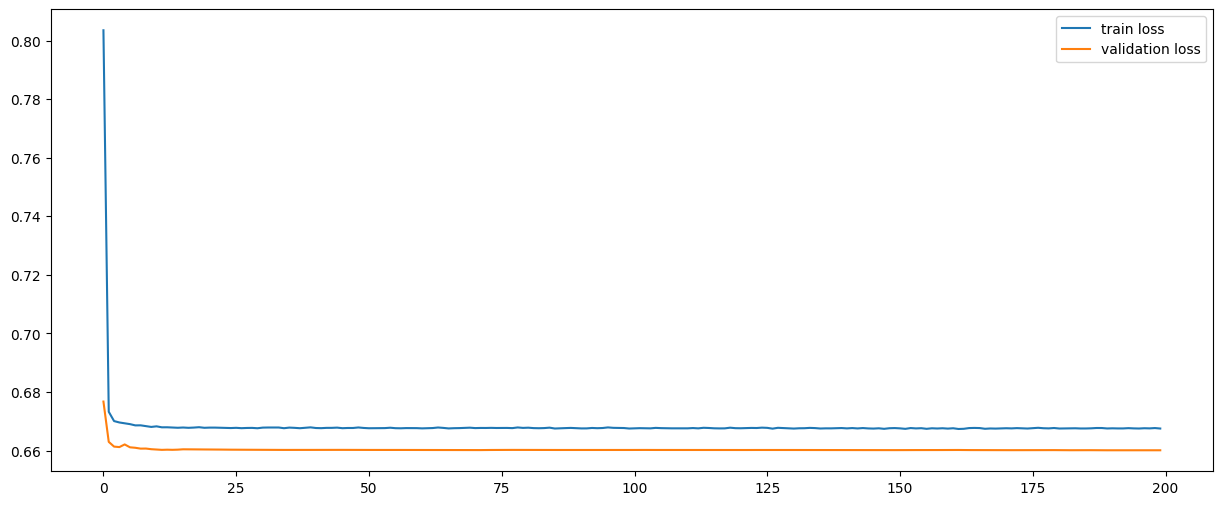

In [20]:
print("------- List Hyper Parameters -------")
print("epochs   ->   " + str(epochs))
print("learningRate   ->   " + str(lr))
print("horizon    ->     " + str(T))
print("batch size   ->    " + str(batch_size))
print("Optimizer   ->    " + str(optimizer))

train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                     epochs)

plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

### **Model Testing**

In [30]:
model = torch.load('./best_model_CTABL')

n_correct = 0.
n_total = 0.
all_targets = []
all_predictions = []

for i, (inputs, targets) in enumerate(test_loader):
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)
    #print(outputs)
    #print(predictions)
    #print(targets)
    #print((predictions == targets).sum().item(), targets.shape[0])

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")
  
all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)    

Test acc: 0.9004


accuracy_score: 0.9004253673627224
              precision    recall  f1-score   support

           0     0.9268    0.8516    0.8876     42518
           1     0.8656    0.9658    0.9130     73154
           2     0.9530    0.8319    0.8883     39488

    accuracy                         0.9004    155160
   macro avg     0.9151    0.8831    0.8963    155160
weighted avg     0.9046    0.9004    0.8997    155160



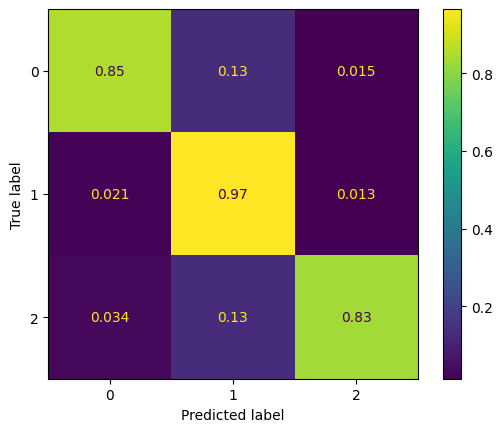

In [31]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

c = confusion_matrix(all_targets, all_predictions, normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()